# Q-Learning and Sparse Incremental Feature Dependency Discovery (iFDD) on discrete Swimmer-v1
### Relevant Documents 
- **Senior Design**: [Final Report](http://nbviewer.jupyter.org/github/huanntran100/Miscellaneous-/blob/master/Group%2012%20Q-Learning%20and%20IFDD%20Final%20Report%20%281%29.pdf)
- **RL Algorithm**: [Q-Learning](https://en.wikipedia.org/wiki/Q-learning) 
- **MIT's Feature Generalization Algorithm**: [Incremental Feature Dependency Discovery](http://people.csail.mit.edu/agf/Homepage/Research/Entries/2011/12/13_Incremental_Feature_Dependency_Discovery.html)
- **Environment**: [Swimmer-v1](https://gym.openai.com/envs/Swimmer-v1/) (3-link, 2-joint snake robot)
- Due to the discrete nature of the Q-learning algorithm and feature representation, I naively discretize the state space to whole number observations between -5 and 5, and the action space to [-0.36, 0, and 0.36] degrees.


### Introduction
- This personal project is meant as an improvement or update of my Bioengineering senior design project, as well as a light investigation the rate or frequency of online feature discovery in terms of reducing learning variance and increasing training speed, the former of which is visually seen as sharp changes in cumulative reward over time. Although the research paper on iFDD itself is old, it was good practice for me to code the algorithm from scratch (I also couldn't find the Github or any tutorial online to double check). I learned how to implement vanilla and adaptive Q-learning linear approximation, as well as derive similar results to the paper but on an untested environment.   

- In the senior design project, we demonstrated statistically significant improvement in locomoted distance (or cumulative reward) of Q-Learning w/ iFDD over a random policy for a 2-jointed robotic snake in Unity3D over at 500,000 time steps. However, we failed to convincingly demonstrate a difference between vanilla Q-Learning vs. Q-Learning w/ iFDD, or visually demonstrate feature generalization at any point during the episode due to the high standard deviation of our iFDD algorithm implementation.   

- Therefore, the motivation for this small project is to bring more closure to the senior project. I expect to get similar results to the paper's pendulum problem, where Q-Learning w/ and w/o iFDD both perform nearly the same, with the latter having a slight but significant advantage. 

### Scope & Goal
- In this project, **the task of the discrete Swimmer agent is to learn to locomote online in the forward direction for a single episode without any prior knowledge of the environment or handcrafted locomotion policy.** A successfully learned action-value function is shown as consistent movement in the forward direction. In the case of the Swimmer environment, this is consistently accumulating positive reward over the episode. 

- **Q-Learning is used over SARSA pedagogically for this project.** In reality, SARSA may be better due to the need of robotic learning to be on-policy for safety reasons. Being on-policy, SARSA chooses to update the weights in the direction of the value of the action it actually takes. Q-Learning, which is off-policy, is "optimistic" as an algorithm due to its "max" operation over the possible next actions, regardless of the action it takes; this is potentially dangerous because the agent might make decisions leading to a bad trajectory over time. 

- Thus, while there are related problems that involve reusing learned weights and feature sets across multiple episodes, the original goal of the senior design project was to achieve learning in a single episode, as if in a real world environment.

### Modifications to iFDD
- Here, I reimplemented the project in Python and Mujoco on the similar Swimmer-v1 environment, and I aim to improve upon the results of the senior design project by showing a clearer difference between the algorithms. In the Python implementation, one of the first things I noticed was that vanilla linear Q-Learning function approximation either did really well or really poorly. Sometimes, the agent will learn a good policy for locomoting forward for the entire episode. Other times, the function will diverge catastrophically, shown as sharp, abrupt fluctuations or consistent movement in the negative direction.  

- I test a single idea to attempt to address all the above problems. By reducing the discovery frequency over the length of the single episode, and sparsely sampling potentially discoverable features (hence "Sparse iFDD"), the agent is still able to generalize faster earlier on, while maintaining adequate computational speed later as more and more features being added to the representation. Furthermore, this appears to stabilize Q-Learning by giving time for the agent to update the newer weights and converge towards the optimal action-value function for that particular feature set, without having to experience a constant, growing feature expansion which slows down learning progress in realtime. 

- Potential issues with this project is that my computer is probably too slow, and some elements of my iFDD implementation may be inefficiently coded. I will continue to improve this project. 

### Summary of Swimmer-v1 Environment
I run the environment randomly to display the raw observations and actions output.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 

import gym
import numpy as np
import time
import tensorflow as tf
import itertools
from itertools import chain
from itertools import combinations

# Setting up the Swimmer-v1 environment
env = gym.make('Swimmer-v1')
env.reset()
for _ in range(50):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if _ % 25 == 0:
        for i in range(len(observation)):
            observation[i] = observation[i]
        print('Example of observation:', observation)
        print('Example of action:', action)

[2018-01-09 16:57:40,200] Making new env: Swimmer-v1


Example of observation: [ 0.03003891 -0.00275563  0.1084795  -0.04034273 -0.07216345  0.08907382
 -0.41998933  0.9724498 ]
Example of action: [ 0.09762701  0.43037873]
Example of observation: [ 0.5160086  -1.28761645  1.55481197  0.33923432 -0.48690073  0.66241947
 -0.61105439 -1.17995882]
Example of action: [ 0.14039354 -0.12279697]


### Q-Learning and Sparse iFDD Algorithm
The following algorithm presented in this notebook is completely based on MIT's paper on [Incremental Feature Dependency Discovery](http://people.csail.mit.edu/agf/Homepage/Research/Entries/2011/12/13_Incremental_Feature_Dependency_Discovery.html) from 2011. Please refer to the paper for more information on iFDD itself. For this report, the following additions were made in response to Q-learning divergence issues I encountered with the discretized Swimmer environment: 
- **Relevance Update Frequency**: using the mathematical MOD function (seen as **(d mod t) == 0** in the code) and doubling the frequency (seen as **d+=d**) every time the discovery algorithm is executed, the relevances of undiscovered features are now updated at progressively lower frequencies over the episode, as opposed to every timestep in the original paper. During early experimentation with iFDD, I saw that if features were added too quickly, the learning diverged and forward locomotion was not achieved in the same time as vanilla Q-Learning.
- **Discovery Probability**: even if a feature's relevance exceeds the threshold, the feature has a probability of GAMMA of not being discovered right away. Again, this is to prevent features from being added too quickly.
- **Adding Previously Unencountered Features**: unencountered features are added to the undiscovered feature set with a probability of THETA. Having too many features in the undiscovered feature set at once increased computational time to the point where training would theoretically take days, which is opposite of the goal of this algorithm.
- **Epsilon-Greedy incrementation**: epsilon is decremented slowly over the episode to reflect the agent becoming more greedy with its action selection as it improves learning and generalization. This is also to prevent too many new features from being encountered too frequently, and encourage the weight-updates among existing discovered features.

Overall, the rate at which features are discovered and added for relevance tracking are decreased significantly in order to stabilize Q-learning. Otherwise, the main idea of original iFDD algorithm remains intact, such as increasing the size of the weights and basis function to account for nonlinearities and to reflect discovering features.  

The Sparse iFDD algorithm I describe is found [[here](https://github.com/huanntran100/Miscellaneous-/blob/master/Q-Learning%20with%20Sparse%20IFDD.PNG?raw=true)].

### Parameters and Features
**Features** are handcrafted, while hyperparameters (epsilon, threshold, gamma, theta, discount factor, learning rate) are selected emperically.  
- **Epsilon**: 0.99 -= 0.0000001 per timestep 
- **Threshold**: 0.9 (roughly double of the max TD error seen in Q-Learning alone)
- **Gamma**= 0.001 (probability of discovering a feature)
- **Theta** = 0.0001 (probability of adding a previously unseen feature to the undiscovered set)
- **Discount Factor** = 0.001 (found by observing Q-Learning alone)
- **Learning Rate** = 0.001 (found by observing Q-Learning alone)


In [13]:
# Method Notebook for Q-Learning and Sparse iFDD
%run QSiFDD.ipynb

[2018-01-09 19:02:10,559] Making new env: Swimmer-v1


State Features: [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5] 
Action Features: [-0.036, 0.0, 0.036] 
Feature Map: [[-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-0.036, 0.0, 0.036], [-0.036, 0.0, 0.036]]


### Results
- We run 3 trials of single episodes of Q-Learning vs. Q-Learning w/ Sparse iFDD, initializing different initial active features each time. This is to demonstrate that Sparse iFDD is robust across different sets of initial features. 
- Episode Length: 1,500,000 time steps
- Discovery Frequency: 475+=475 every time the Sparse iFDD algorithm executes 

-------BEGIN 3 trials of Q-Learning vs. Q-Learning w/ Sparse iFDD for 1500000 episodes.-------
Trial: 1
Initial Active Features for Current Trial: [3, 14, 23, 34, 44, 58, 66, 79, 89, 93]
-----------Q-Learning-----------
Len Initial Discovered Set: 10 
Len Initial Undiscovered Set: 1013
Timestep: 0 Time elapsed: 0.21 Cumulative Reward: 0
Timestep: 500000 Time elapsed: 181.68 Cumulative Reward: -10.3343
Timestep: 1000000 Time elapsed: 363.19 Cumulative Reward: 75.8652
Timestep: 1500000 Time elapsed: 536.64 Cumulative Reward: 199.9587
Training Time: 536.64
-----------Q-Learning w/ Sparse iFDD-----------
Len Initial Discovered Set: 10 
Len Initial Undiscovered Set: 1013
Timestep: 0 Elapsed: 0.07 DISCOVERED: 10 UNDISCOVERED: 1013 Basis: 94 Weights: 94 Cumul. Reward: 0
Timestep: 500000 Elapsed: 296.71 DISCOVERED: 13 UNDISCOVERED: 1127 Basis: 97 Weights: 97 Cumul. Reward: 189.7189
Timestep: 1000000 Elapsed: 1017.93 DISCOVERED: 38 UNDISCOVERED: 1214 Basis: 122 Weights: 122 Cumul. Reward: 145.6

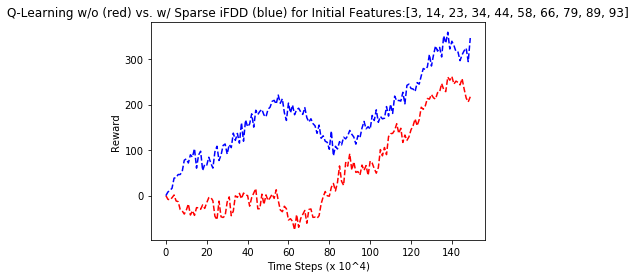

Time Elapsed: 5634.2
Trial: 2
Initial Active Features for Current Trial: [3, 11, 22, 36, 46, 58, 66, 81, 89, 91]
-----------Q-Learning-----------
Len Initial Discovered Set: 10 
Len Initial Undiscovered Set: 1013
Timestep: 0 Time elapsed: 0.01 Cumulative Reward: 0
Timestep: 500000 Time elapsed: 180.77 Cumulative Reward: 26.0524
Timestep: 1000000 Time elapsed: 354.92 Cumulative Reward: 206.2824
Timestep: 1500000 Time elapsed: 528.75 Cumulative Reward: 170.7405
Training Time: 528.75
-----------Q-Learning w/ Sparse iFDD-----------
Len Initial Discovered Set: 10 
Len Initial Undiscovered Set: 1013
Timestep: 0 Elapsed: 0.07 DISCOVERED: 10 UNDISCOVERED: 1013 Basis: 94 Weights: 94 Cumul. Reward: 0
Timestep: 500000 Elapsed: 462.0 DISCOVERED: 30 UNDISCOVERED: 1106 Basis: 114 Weights: 114 Cumul. Reward: 193.0134
Timestep: 1000000 Elapsed: 1778.74 DISCOVERED: 48 UNDISCOVERED: 1194 Basis: 132 Weights: 132 Cumul. Reward: 385.3396
Timestep: 1500000 Elapsed: 10451.08 DISCOVERED: 171 UNDISCOVERED: 127

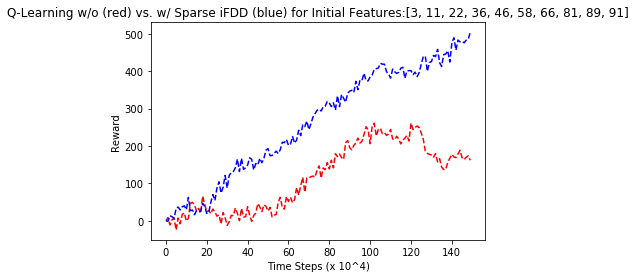

Time Elapsed: 16614.32
Trial: 3
Initial Active Features for Current Trial: [2, 12, 26, 37, 47, 56, 69, 77, 90, 92]
-----------Q-Learning-----------
Len Initial Discovered Set: 10 
Len Initial Undiscovered Set: 1013
Timestep: 0 Time elapsed: 0.01 Cumulative Reward: 0
Timestep: 500000 Time elapsed: 169.7 Cumulative Reward: 171.149
Timestep: 1000000 Time elapsed: 339.13 Cumulative Reward: 111.9019
Timestep: 1500000 Time elapsed: 508.18 Cumulative Reward: 89.7265
Training Time: 508.18
-----------Q-Learning w/ Sparse iFDD-----------
Len Initial Discovered Set: 10 
Len Initial Undiscovered Set: 1013
Timestep: 0 Elapsed: 0.06 DISCOVERED: 10 UNDISCOVERED: 1013 Basis: 94 Weights: 94 Cumul. Reward: 0
Timestep: 500000 Elapsed: 402.69 DISCOVERED: 20 UNDISCOVERED: 1117 Basis: 104 Weights: 104 Cumul. Reward: 69.9835
Timestep: 1000000 Elapsed: 1316.14 DISCOVERED: 48 UNDISCOVERED: 1211 Basis: 132 Weights: 132 Cumul. Reward: 227.3146
Timestep: 1500000 Elapsed: 5404.91 DISCOVERED: 93 UNDISCOVERED: 1311 

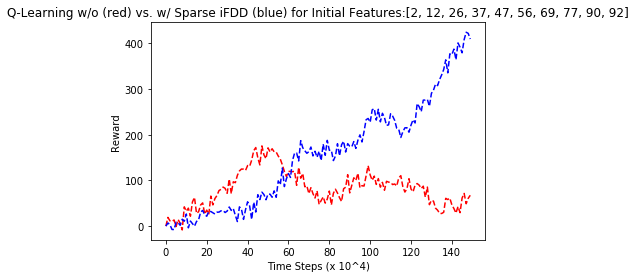

Time Elapsed: 22527.68
Experiment complete!
Total Training Time: 6.26 hours


In [18]:
batchQSiFDDTrain(trials = 3, epsilon = 0.99, episodeLen = 1500000, myDiscoverFrequency = 475)

### Discussion
Over all three trials, Q-Learning and Sparse iFDD outperformed Q-Learning alone. While Sparse iFDD takes much longer too train, we can assume that in a real environment, computational power is not an issue and both can run at similar speeds. It is worth noting that with my implementation, the time for 500,000 timesteps with Sparse iFDD increases roughly 5x every time as more features are accumulated, while vanilla Q-Learning stays constant.  
- In trials 1 and 2, both agents learn to locomote forward in the latter half of the episode. It is noted that in trial 1, the agent discovering only 3 new features before 500,000 timesteps causes it to locomote backwards while still staying ahead of the vanilla agent. This is probably due to the feature representation being too similar to that of the vanilla agent, causing temporary learning divergence. 

- In trial 3, the vanilla Q-Learning agent fails to locomote forward while the other one does. We can clearly see where slow generalization benefits the sparse IFDD agent, with rapid forward locomotion at around 600,000 and 1,000,000 timesteps, as well as after 1,200,000 timesteps.  